# read_seeclickfix_api

This notebook describes how to use python to read in the seeclickfix API to a pandas DataFrame

In [1]:
import json
import urllib2
import pandas as pd
from jq import jq
import matplotlib.pyplot as plt
import numpy as np

/Applications/anaconda/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


In [2]:
%matplotlib inline

## Extracting the Categories

The SeeClickFix Public API does not include the category in the output. Furthermore, the categories are non-standard (i.e., they vary from municipality to municipality). However, there is a solution! We can request all the categories from New Haven from the SeeClickFix API, and then request the issues for each category individually. This will allow us to associate a category with each issue.

In [8]:
#json_cats = json.load(urllib2.urlopen('https://seeclickfix.com/api/v2/issues/new?address=New+Haven,+CT'))
json_cats = json.load(open('/Users/matt/projects/nhrc2/data/scf_cats.json', 'r'))

In [9]:
scf_cat_rule = '[.[] | .[] | {title: .title, url: .url, organization: .organization}]'

In [13]:
scf_cat_df = pd.DataFrame(jq(scf_cat_rule).transform(json_cats))
scf_cat_df['type'] = [urlstr.split('/')[-1] for urlstr in scf_cat_df['url']]

In [16]:
print('Number of categories for New Haven: {}'.format(len(scf_cat_df)))
scf_cat_df.head(5)

Number of categories for New Haven: 25


,organization,title,url,type
0,City of New Haven,SNOW RELATED,https://seeclickfix.com/api/v2/request_types/8516,8516
1,City of New Haven,Bins for Trash & Recycling,https://seeclickfix.com/api/v2/request_types/5743,5743
2,City of New Haven,Graffiti,https://seeclickfix.com/api/v2/request_types/122,122
3,City of New Haven,Hangers,https://seeclickfix.com/api/v2/request_types/6215,6215
4,City of New Haven,Health Complaints,https://seeclickfix.com/api/v2/request_types/5185,5185


## Extracting the Issues

In [21]:
#json_data = json.load(urllib2.urlopen('https://seeclickfix.com/api/v2/issues?place_url=new-haven&page=1&per_page=10'))
json_data = json.load(urllib2.urlopen('https://seeclickfix.com/api/v2/issues?request_types=116&per_page=100000'))

In [12]:
#json_data

In [4]:
json_data.keys()

[u'errors', u'issues', u'metadata']

In [5]:
json_data['issues'][0]

{u'acknowledged_at': u'2015-03-30T16:06:17-04:00',
 u'address': u'Fairmont Ave  New Haven, Connecticut',
 u'closed_at': None,
 u'comment_url': u'https://seeclickfix.com/api/v2/issues/1561282/comments',
 u'created_at': u'2015-03-30T15:10:43-04:00',
 u'description': u'From Fairmount Ave right down to Forbes Ave the pot holes are like driving through a mine field. Something has to be done. Been pointing this stretch for years and nothing is getting done. "NOTHING"! ',
 u'flag_url': u'https://seeclickfix.com/api/v2/issues/1561282/flag',
 u'html_url': u'https://seeclickfix.com/issues/1561282',
 u'id': 1561282,
 u'lat': 41.2967237,
 u'lng': -72.8939387,
 u'media': {u'image_full': None,
  u'image_square_100x100': None,
  u'representative_image_url': u'https://seeclickfix.com/assets/categories_trans/no-image.png',
  u'video_url': None},
 u'point': {u'coordinates': [-72.8939387, 41.2967237], u'type': u'Point'},
 u'rating': 3,
 u'reporter': {u'avatar': {u'full': u'https://seeclickfix.com/assets/

In [88]:
scf_iss_rule = '.issues | {id: .[] .id, status: .[] .status, lat: .[] .lat, lng: .[] .lng}'
scf_issues = jq(scf_iss_rule).transform(json_data)

In [6]:
#scf_issues

In [7]:
dict_lst_rule = '.issues | {id: [.[] .id], status: [.[] .status]}'
#jq(dict_lst_rule).transform(json_data)

In [48]:
record_rule = ("[.issues | .[] | {"
               "id: .id, "
               "status: .status,"
               "summary: .summary,"
               "address: .address,"
               "lat: .lat,"
               "lng: .lng,"
               "closed_at: .closed_at,"
               "acknowledged_at: .acknowledged_at,"
               "created_at: .created_at,"
               "updated_at: .updated_at,"
               "shortened_url: .shortened_url,"
               "reporter_id: .reporter.id,"
               "reporter_name: .reporter.name,"
               "reporter_role: .reporter.role,"
               "}]")
#jq(record_rule).transform(json_data)

In [26]:
scf_df = pd.DataFrame(jq(record_rule).transform(json_data))

In [27]:
print('number of records: {}'.format(len(scf_df)))
scf_df.head(10)

number of records: 970


,acknowledged_at,address,closed_at,created_at,id,lat,lng,shortened_url,status,summary,updated_at
0,2015-03-30T16:06:17-04:00,"Fairmont Ave New Haven, Connecticut",None,2015-03-30T15:10:43-04:00,1561282,41.296724,-72.893939,http://bit.ly/1abCoSL,Acknowledged,Potholes,2015-03-30T16:06:17-04:00
1,2015-03-30T16:06:49-04:00,"422 West Rock Ave New Haven, Connecticut",None,2015-03-30T13:00:27-04:00,1560970,41.310373,-72.924160,http://bit.ly/1NuPYg9,Acknowledged,Potholes,2015-03-30T16:06:49-04:00
2,2015-03-30T16:07:06-04:00,"Burwell & Chester Street New Haven, Connecticut",None,2015-03-30T12:51:03-04:00,1560961,41.291623,-72.891071,http://bit.ly/1NuNNJA,Acknowledged,Potholes,2015-03-30T16:25:45-04:00
3,2015-03-30T16:07:41-04:00,"125-127 Foxon Hill Road New Haven, Connecticut",None,2015-03-30T11:36:29-04:00,1560625,41.331581,-72.864828,http://bit.ly/1NutAUh,Acknowledged,Potholes,2015-03-30T16:07:41-04:00
4,2015-03-30T16:08:04-04:00,"130 Hamilton Street New Haven, Connecticut",None,2015-03-30T11:22:59-04:00,1560603,41.307181,-72.913159,http://bit.ly/1GH0bGv,Acknowledged,Potholes,2015-03-30T16:08:04-04:00
5,2015-03-30T16:08:30-04:00,"Irving Street New Haven, Connecticut",None,2015-03-30T10:46:31-04:00,1560445,41.311754,-72.950828,http://bit.ly/1GGVaxy,Acknowledged,Potholes,2015-03-30T16:08:30-04:00
6,2015-03-30T16:05:04-04:00,"703 Whitney Avenue New Haven, Connecticut",None,2015-03-30T09:31:36-04:00,1560123,41.329436,-72.913558,http://bit.ly/1yswORb,Acknowledged,Potholes,2015-03-30T16:05:04-04:00
7,2015-03-30T08:55:09-04:00,"143 Rowe Street New Haven, CT 06513, USA",None,2015-03-30T06:17:20-04:00,1559906,41.316952,-72.895774,http://bit.ly/1G7ROTP,Acknowledged,Potholes,2015-03-30T08:55:10-04:00
8,2015-03-30T08:55:10-04:00,"Farnam Drive New Haven, CT 06511, USA",None,2015-03-29T22:10:35-04:00,1559822,41.327643,-72.908235,http://bit.ly/1IIzxfy,Acknowledged,Potholes,2015-03-30T08:55:10-04:00
9,2015-03-30T16:02:52-04:00,"111 Linden Street New Haven, CT 06511, USA",None,2015-03-29T13:00:10-04:00,1559298,41.321984,-72.913699,http://bit.ly/1FZwukI,Acknowledged,Testing for scf #seeclickfix #pothole,2015-03-30T16:02:52-04:00


### Merge two DataFrames

In [39]:
i=0
print(scf_cat_df.loc[i, 'title'], scf_cat_df.loc[i, 'type'])
issurl = 'https://seeclickfix.com/api/v2/issues?request_types='+scf_cat_df.loc[i, 'type']+'&per_page=100000'
json_data = json.load(urllib2.urlopen(issurl))
scf_iss_df = pd.DataFrame(jq(record_rule).transform(json_data))

(u'SNOW RELATED', u'8516')


In [41]:
print(len(scf_iss_df))

569


In [42]:
scf_df = scf_df.append(scf_iss_df, ignore_index=True)

In [43]:
len(scf_df)

1539

### Looping over all issue categories

So far we have seen how to get the SeeClickFix issue categories for a municipality, request all issues for a particular category, and merge the results to an existing DataFrame. The next step is to loop over all categories, request all issues, and save them all to a huge DataFrame.

In [45]:
tstdf = pd.DataFrame(columns=['id', 'status', 'summary', 'address', 'lat', 'lng', 'closed_at', 'acknowledged_at',
                              'created_at', 'updated_at', 'shortened_url', 'issue_id', 'category'])
tstdf

,id,status,summary,address,lat,lng,closed_at,acknowledged_at,created_at,updated_at,shortened_url


In [50]:
scf_df = pd.DataFrame(columns=['id', 'status', 'summary', 'address', 'lat', 'lng', 'closed_at', 'acknowledged_at',
                              'created_at', 'updated_at', 'shortened_url', 
                              'reporter_id', 'reporter_name', 'reporter_role',
                              'issue_id', 'category'])

for i in scf_cat_df.index:
    print(scf_cat_df.loc[i, 'title'], scf_cat_df.loc[i, 'type'])
    issurl = 'https://seeclickfix.com/api/v2/issues?request_types='+scf_cat_df.loc[i, 'type']+'&per_page=10000'
    json_data = json.load(urllib2.urlopen(issurl))
    scf_iss_df = pd.DataFrame(jq(record_rule).transform(json_data))
    scf_iss_df['issue_id'] = scf_cat_df.loc[i, 'type']
    scf_iss_df['category'] = scf_cat_df.loc[i, 'title']
    scf_df = scf_df.append(scf_iss_df, ignore_index=True)

(u'SNOW RELATED', u'8516')
(u'Bins for Trash & Recycling', u'5743')
(u'Graffiti', u'122')
(u'Hangers', u'6215')
(u'Health Complaints', u'5185')
(u'Illegal Dumping', u'1250')
(u'Other', u'374')
(u'Other - city responsibility', u'3018')
(u'Parking Meter', u'372')
(u'Parking Violation/Abandoned Auto', u'121')
(u'Parks Request', u'126')
(u'Policing Issue', u'2626')
(u'Potholes', u'116')
(u'Public Space, Streets and Drains', u'1249')
(u'Private Property Issue', u'1251')
(u'Sidewalks and Curb damage', u'117')
(u'Signs / Bus Shelters / Pavement Markings', u'373')
(u'Street Lamp', u'124')
(u'Traffic/Road Safety', u'2625')
(u'Traffic Signal / Pedestrian Signal', u'51')
(u'Trash & Recycling', u'1966')
(u'Tree Trimming', u'1853')
(u'Request for volunteers', u'5998')
(u'General Bus Request/Incident', u'4947')
(u'Post to Neighbors', u'other')


In [51]:
print(len(scf_df))
scf_df.head(5)

9037


,acknowledged_at,address,category,closed_at,created_at,id,issue_id,lat,lng,reporter_id,reporter_name,reporter_role,shortened_url,status,summary,updated_at
0,2015-03-30T16:03:33-04:00,"25 Elmer Street New Haven, Connecticut",SNOW RELATED,None,2015-03-29T17:18:53-04:00,1559551,8516,41.310373,-72.924160,0,CAROL SANTACROCE,Registered User,http://bit.ly/1HVR8D7,Acknowledged,SNOW RELATED,2015-03-30T16:03:33-04:00
1,None,"Lenox Street And Clifton Street New Haven, Co...",SNOW RELATED,None,2015-03-17T12:04:30-04:00,1536264,8516,41.309046,-72.884204,6774,Department of Public Works,Verified Official,http://bit.ly/19w8mbW,Open,Unshoveled Sidewalks,2015-03-17T12:04:30-04:00
2,None,"591 Whitney Avenue New Haven, Connecticut",SNOW RELATED,None,2015-03-16T17:17:58-04:00,1534432,8516,41.326617,-72.915233,0,An anonymous SeeClickFix user,Registered User,http://bit.ly/1GeXnOd,Open,SNOW RELATED,2015-03-16T17:17:58-04:00
3,2015-03-16T11:04:17-04:00,"900 Block Of State St New Haven, Connecticut",SNOW RELATED,None,2015-03-16T10:21:24-04:00,1533208,8516,41.314704,-72.911942,0,PamB,Registered User,http://bit.ly/1Ds46Xu,Acknowledged,SNOW RELATED,2015-03-16T15:36:34-04:00
4,None,"112-116 Court Street New Haven, Connecticut",SNOW RELATED,None,2015-03-16T08:34:55-04:00,1532841,8516,41.305827,-72.922153,0,An anonymous SeeClickFix user,Registered User,http://bit.ly/1BJ8azg,Open,SNOW RELATED,2015-03-16T08:58:48-04:00


In [60]:
scf_df.to_csv('/Users/matt/projects/nhrc2/data/scf_data_full.csv', sep=',', encoding='utf-8')

(41.24, 41.355)

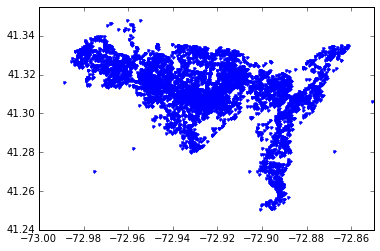

In [111]:
plt.plot(scf_df['lng'], scf_df['lat'], '.')
plt.xlim([-73.0, -72.85])
plt.ylim([41.24, 41.355])

In [106]:
scf_df['issue_id'].values

array([u'8516', u'8516', u'8516', ..., u'other', u'other', u'other'], dtype=object)

In [112]:
issue_ints = scf_df['issue_id'].values

In [117]:
issue_ints[np.where(issue_ints == 'other')[0]] = -1

In [129]:
scf_df['issue_id'] = scf_df['issue_id'].astype('str')

In [136]:
new_ints = [int(i) for i in issue_ints]

In [143]:
np.unique(new_ints)

array([  -1,   51,  116,  117,  121,  122,  124,  126,  372,  373,  374,
       1249, 1250, 1251, 1853, 1966, 2625, 2626, 3018, 4947, 5185, 5743,
       5998, 6215, 8516])

In [153]:
np.unique(scf_df[['issue_id', 'category']])

array(['-1', '116', '117', '121', '122', '124', '1249', '1250', '1251',
       '126', '1853', '1966', '2625', '2626', '3018', '372', '373', '374',
       '4947', '51', '5185', '5743', '5998', '6215', '8516',
       u'Bins for Trash & Recycling', u'General Bus Request/Incident',
       u'Graffiti', u'Hangers', u'Health Complaints', u'Illegal Dumping',
       u'Other', u'Other - city responsibility', u'Parking Meter',
       u'Parking Violation/Abandoned Auto', u'Parks Request',
       u'Policing Issue', u'Post to Neighbors', u'Potholes',
       u'Private Property Issue', u'Public Space, Streets and Drains',
       u'Request for volunteers', u'SNOW RELATED',
       u'Sidewalks and Curb damage',
       u'Signs / Bus Shelters / Pavement Markings', u'Street Lamp',
       u'Traffic Signal / Pedestrian Signal', u'Traffic/Road Safety',
       u'Trash & Recycling', u'Tree Trimming'], dtype=object)

In [154]:
scf_df['category_str'] = [str(i) for i in scf_df['category']]

In [158]:
scf_df.hist(scf_df, column='category_str')

TypeError: hist_frame() got multiple values for keyword argument 'column'

(array([ 4768.,  1169.,  1388.,  1064.,     0.,    19.,    51.,     9.,
            0.,   569.]),
 array([ -1.00000000e+00,   8.50700000e+02,   1.70240000e+03,
          2.55410000e+03,   3.40580000e+03,   4.25750000e+03,
          5.10920000e+03,   5.96090000e+03,   6.81260000e+03,
          7.66430000e+03,   8.51600000e+03]),
 <a list of 10 Patch objects>)

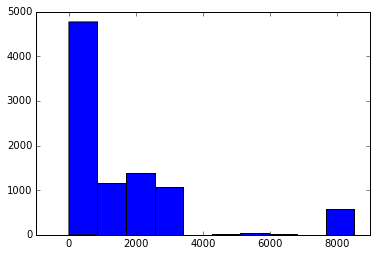

In [137]:
plt.hist(new_ints)
plt.xticks